In [1]:
import time

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv1D, Dense,  MaxPooling2D, MaxPooling1D, Flatten, Concatenate, GlobalAveragePooling2D, GlobalAveragePooling1D

2024-11-16 16:10:03.666584: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-16 16:10:03.667126: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-16 16:10:03.667174: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 16:10:03.677688: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.__version__

'2.14.1'

In [3]:
PATH = "/tmp/lhcf-cnn"

In [4]:
# Define the TFRecord schema
feature_description = {
    "posdE_01xy": tf.io.FixedLenFeature([384 * 384 * 2], tf.float32),
    "posdE_23x": tf.io.FixedLenFeature([384 * 2], tf.float32),
    "posdE_23y": tf.io.FixedLenFeature([384 * 2], tf.float32),
    "dE": tf.io.FixedLenFeature([16], tf.float32),
    "label": tf.io.FixedLenFeature([], tf.int64)
}

# Function to parse TFRecord records
def parse_tfrecord_fn(example_proto):
    example = tf.io.parse_single_example(example_proto, feature_description)
    
    # Reconstruct the original shapes
    posdE_01xy = tf.reshape(example["posdE_01xy"], (384, 384, 2))
    posdE_23x = tf.reshape(example["posdE_23x"], (384, 2))
    posdE_23y = tf.reshape(example["posdE_23y"], (384, 2))
    dE = tf.reshape(example["dE"], (16,))
    label = example["label"]
    
    return {"posdE_01xy_input": posdE_01xy, "posdE_23x_input": posdE_23x, "posdE_23y_input": posdE_23y, "dE_input": dE}, label

# Load and preprocess data in batches
def load_dataset(tfrecord_file, batch_size=32, shuffle_buffer=1000):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle_buffer == None:
        dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    else:
        dataset = dataset.shuffle(shuffle_buffer).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create training and validation datasets
train_dataset = load_dataset(f"{PATH}/train.tfrecord", batch_size=32)
validation_dataset = load_dataset(f"{PATH}/validation.tfrecord", batch_size=32, shuffle_buffer=None)

2024-11-16 16:10:07.017550: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3234 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 1g.5gb, pci bus id: 0000:e1:00.0, compute capability: 8.0


In [5]:
train_dataset.element_spec

({'posdE_01xy_input': TensorSpec(shape=(None, 384, 384, 2), dtype=tf.float32, name=None),
  'posdE_23x_input': TensorSpec(shape=(None, 384, 2), dtype=tf.float32, name=None),
  'posdE_23y_input': TensorSpec(shape=(None, 384, 2), dtype=tf.float32, name=None),
  'dE_input': TensorSpec(shape=(None, 16), dtype=tf.float32, name=None)},
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [6]:
train_dataset_noshuffle = load_dataset(f"{PATH}/train.tfrecord", batch_size=32, shuffle_buffer=None)

In [7]:
# Count the number of examples with label 0 and 1 in the train_dataset
count_label_0 = 0
count_label_1 = 0

# Iterate over the train_dataset to count the labels
for _, labels in train_dataset:
    # Convert the label tensors to numpy for easy operations
    labels_numpy = labels.numpy()
    count_label_0 += np.sum(labels_numpy == 0)
    count_label_1 += np.sum(labels_numpy == 1)

print(f"Number of examples with label 0: {count_label_0}")
print(f"Number of examples with label 1: {count_label_1}")
ratio = count_label_0 / count_label_1
print("Ratio: ", ratio)

Number of examples with label 0: 6123
Number of examples with label 1: 1877
Ratio:  3.2621204049014385


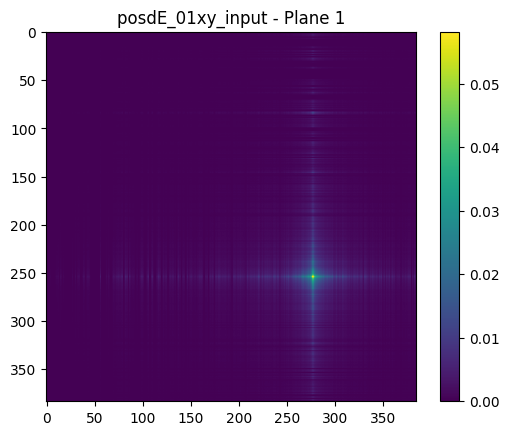

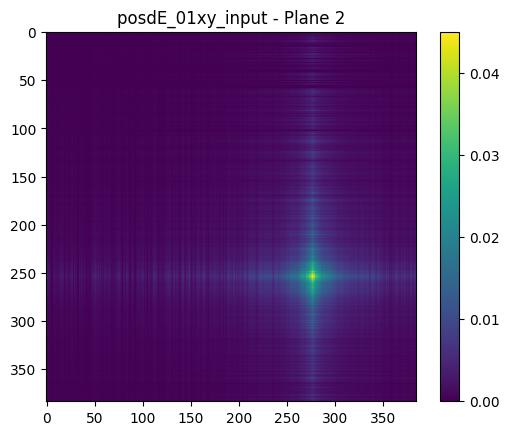

In [8]:
# Extract a batch from the dataset
for batch in train_dataset_noshuffle.take(1):  # Take the first batch
    example = batch[0]  # Extract features
    label = batch[0]  # Extract labels
    break

# Extract a single example
posdE_01xy_example = example["posdE_01xy_input"].numpy()[2]  # Get the second example from the batch

# Visualize the image from posdE_01xy_input
plt.imshow(posdE_01xy_example[:, :, 0], cmap='viridis')  # Display the first channel
plt.colorbar()
plt.title("posdE_01xy_input - Plane 1")
plt.show()

# To visualize the second channel separately
plt.imshow(posdE_01xy_example[:, :, 1], cmap='viridis')  # Display the second channel
plt.colorbar()
plt.title("posdE_01xy_input - Plane 2")
plt.show()

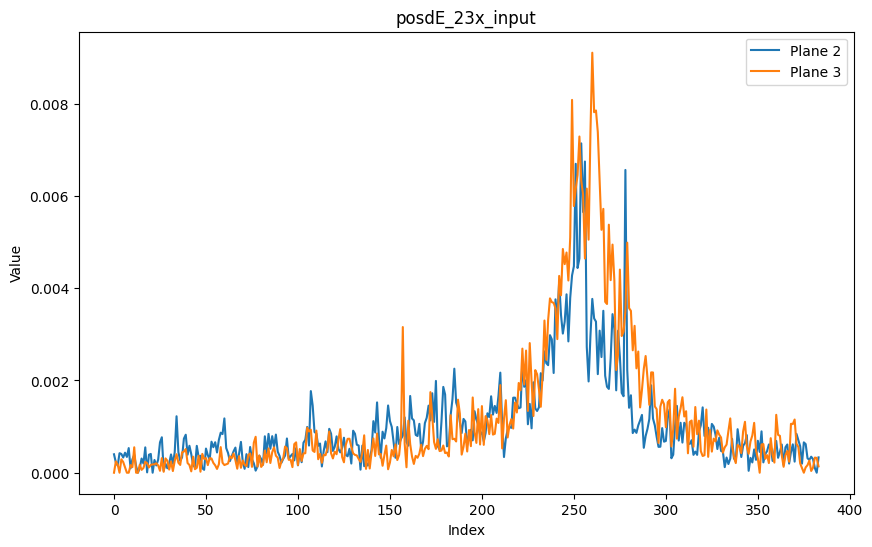

In [9]:
# Extract a batch from the dataset
for batch in train_dataset_noshuffle.take(1):  # Take the first batch
    example = batch[0]  # Extract features
    label = batch[0]  # Extract labels
    break

# Extract a single example
posdE_23x_example = example["posdE_23x_input"].numpy()[2]  # Get the second example from the batch

# Visualize the two channels as separate lines
plt.figure(figsize=(10, 6))
plt.plot(posdE_23x_example[:, 0], label="Plane 2")
plt.plot(posdE_23x_example[:, 1], label="Plane 3")
plt.title("posdE_23x_input")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()


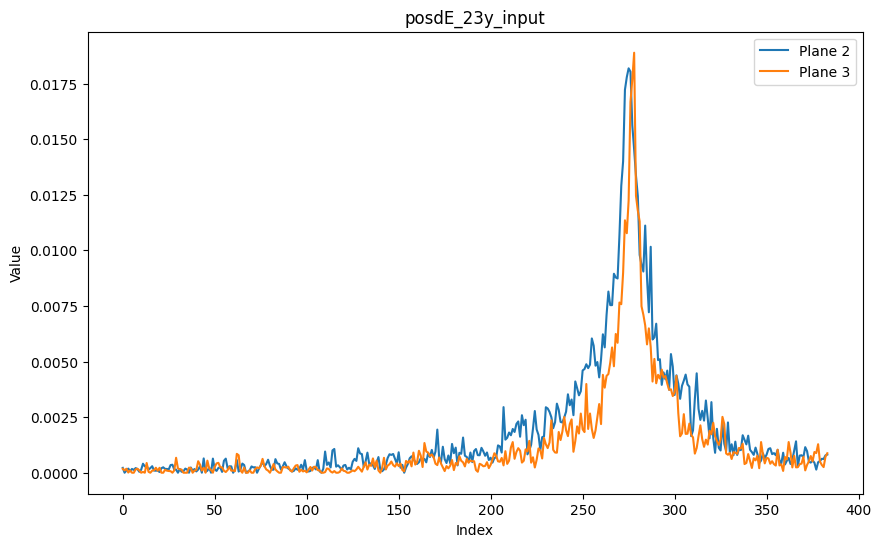

In [10]:
# Extract a batch from the dataset
for batch in train_dataset_noshuffle.take(1):  # Take the first batch
    example = batch[0]  # Extract features
    label = batch[0]  # Extract labels
    break

# Extract a single example
posdE_23y_example = example["posdE_23y_input"].numpy()[2]  # Get the second example from the batch

# Visualize the two channels as separate lines
plt.figure(figsize=(10, 6))
plt.plot(posdE_23y_example[:, 0], label="Plane 2")
plt.plot(posdE_23y_example[:, 1], label="Plane 3")
plt.title("posdE_23y_input")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()

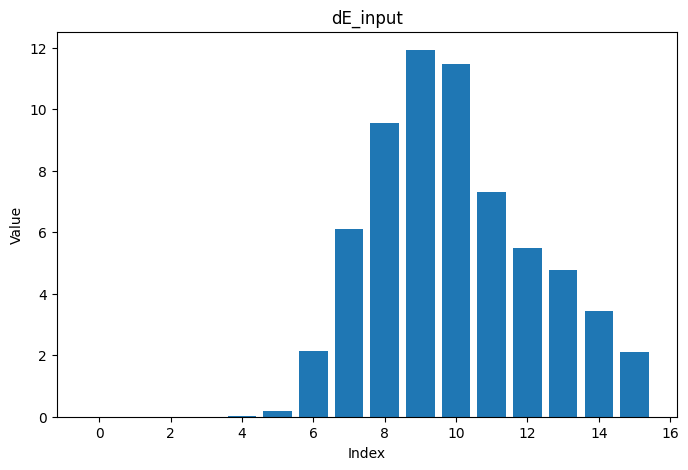

In [11]:
# Extract a batch from the dataset
for batch in train_dataset.take(1):  # Take the first batch
    example = batch[0]  # Extract features
    label = batch[0]  # Extract labels
    break

# Extract a single example of dE_input
dE_example = example["dE_input"].numpy()[2]  # Get the second example from the batch

# Visualize dE_input as a bar chart
plt.figure(figsize=(8, 5))
plt.bar(range(len(dE_example)), dE_example)
plt.title("dE_input")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()

In [12]:
# Neural Network Definition

# Input for Conv2D 
input_posdE_01xy = Input(shape=(384, 384, 2), name="posdE_01xy_input")
x1 = Conv2D(4, (3, 3), activation="relu", padding="same")(input_posdE_01xy)
x1 = MaxPooling2D((2, 2))(x1)
# Uncomment this line to reduce parameters further
# x1 = GlobalAveragePooling2D()(x1)
x1 = Flatten()(x1)

# Input for Conv1D 
input_posdE_23x = Input(shape=(384, 2), name="posdE_23x_input")
x2 = Conv1D(4, 3, activation="relu", padding="same")(input_posdE_23x)
x2 = MaxPooling1D(2)(x2)
# Uncomment this line to reduce parameters further
# x2 = GlobalAveragePooling1D()(x2)
x2 = Flatten()(x2)

input_posdE_23y = Input(shape=(384, 2), name="posdE_23y_input")
x3 = Conv1D(4, 3, activation="relu", padding="same")(input_posdE_23y)
x3 = MaxPooling1D(2)(x3)
# Uncomment this line to reduce parameters further
# x3 = GlobalAveragePooling1D()(x3)
x3 = Flatten()(x3)

# Input for Dense
input_dE = Input(shape=(16,), name="dE_input")
x4 = Dense(4, activation="relu")(input_dE)

# Combine the outputs of all branches
x = Concatenate()([x1, x2, x3, x4])

# Output for binary classification
output = Dense(1, activation="sigmoid", name="output")(x)

# Define the model
model = Model(inputs=[input_posdE_01xy, input_posdE_23x, input_posdE_23y, input_dE], outputs=output)

In [13]:
# Compile the model
from tensorflow.keras.metrics import AUC
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", AUC()])

# Display the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 posdE_01xy_input (InputLay  [(None, 384, 384, 2)]        0         []                            
 er)                                                                                              
                                                                                                  
 posdE_23x_input (InputLaye  [(None, 384, 2)]             0         []                            
 r)                                                                                               
                                                                                                  
 posdE_23y_input (InputLaye  [(None, 384, 2)]             0         []                            
 r)                                                                                           

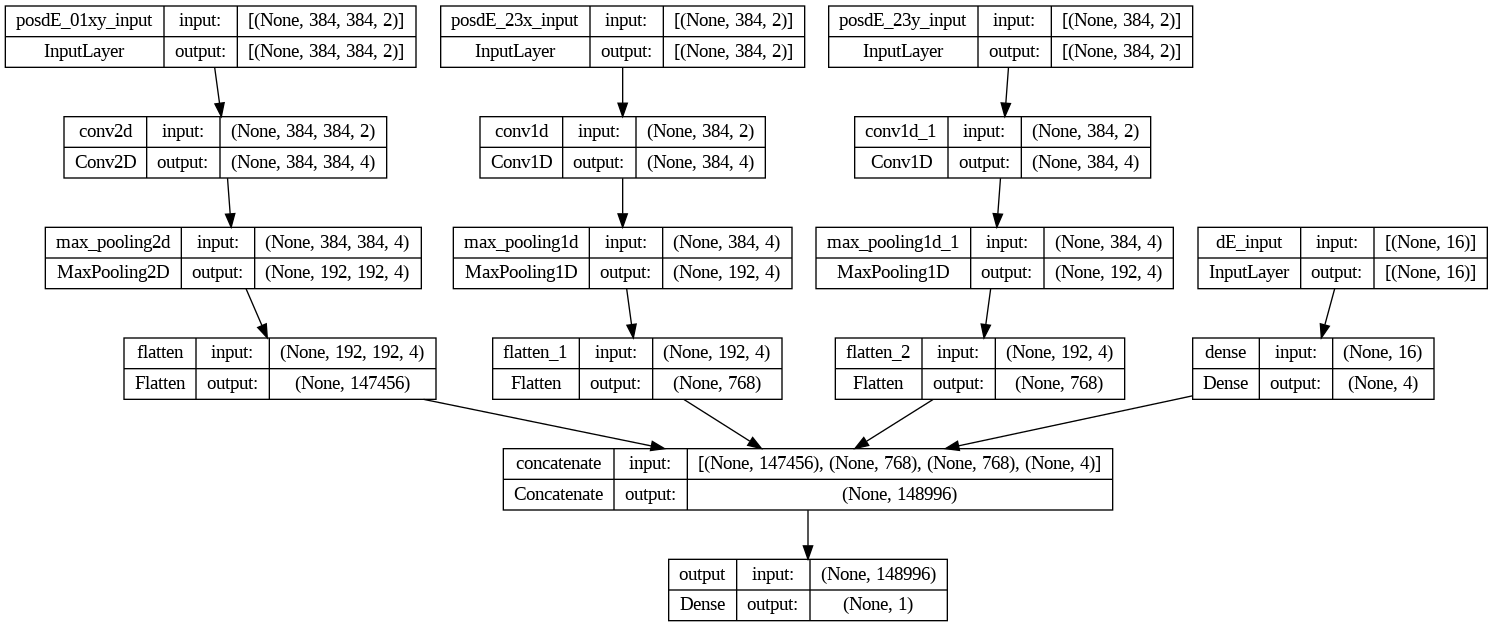

In [14]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [15]:
# Define class weights (optional)
# class_weight = {0: 1, 1: 3}

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,
    # class_weight=class_weight
)

Epoch 1/5


2024-11-16 16:10:15.968927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-11-16 16:10:16.016899: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-16 16:10:16.109167: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-16 16:10:17.951548: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbc0911dbe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-16 16:10:17.951632: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB MIG 1g.5gb, Compute Capability 8.0
2024-11-16 16:10:17.957718: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-16 16:10:18.141975: I ./tensorflow/compiler/jit/de

    249/Unknown - 12s 28ms/step - loss: 0.4370 - accuracy: 0.7905 - auc: 0.8195

2024-11-16 16:10:26.739403: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12840239856580077957
2024-11-16 16:10:26.739762: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14779163920010804127
2024-11-16 16:10:26.739800: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3070380579739779244
2024-11-16 16:10:26.739822: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3091708385111851092
2024-11-16 16:10:26.739844: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 105488140647324174
2024-11-16 16:10:26.739890: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5532087329531528180


250/250 [==============================] - 14s 35ms/step - loss: 0.4365 - accuracy: 0.7908 - auc: 0.8201 - val_loss: 0.3249 - val_accuracy: 0.8285 - val_auc: 0.9638


2024-11-16 16:10:28.605683: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14779163920010804127
2024-11-16 16:10:28.605799: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18178211622523239523
2024-11-16 16:10:28.605828: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1325666164035569481
2024-11-16 16:10:28.605855: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3070380579739779244
2024-11-16 16:10:28.605893: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5532087329531528180


Epoch 2/5
250/250 [==============================] - 9s 33ms/step - loss: 0.2729 - accuracy: 0.8938 - auc: 0.9627 - val_loss: 0.2491 - val_accuracy: 0.8905 - val_auc: 0.9785
Epoch 3/5
250/250 [==============================] - 9s 33ms/step - loss: 0.1972 - accuracy: 0.9360 - auc: 0.9824 - val_loss: 0.1732 - val_accuracy: 0.9520 - val_auc: 0.9868
Epoch 4/5
250/250 [==============================] - 9s 33ms/step - loss: 0.1516 - accuracy: 0.9523 - auc: 0.9881 - val_loss: 0.1478 - val_accuracy: 0.9490 - val_auc: 0.9873
Epoch 5/5
250/250 [==============================] - 9s 33ms/step - loss: 0.1253 - accuracy: 0.9595 - auc: 0.9911 - val_loss: 0.1331 - val_accuracy: 0.9690 - val_auc: 0.9942


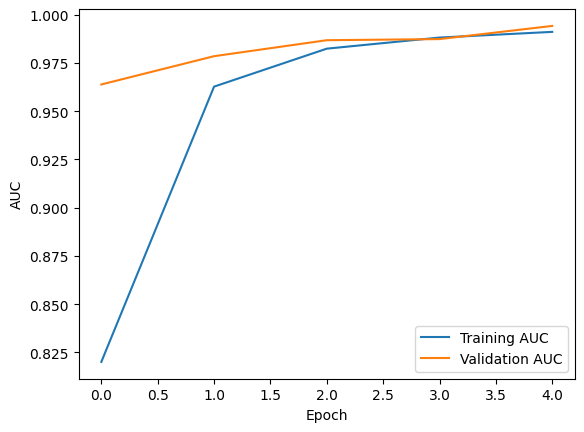

In [16]:
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

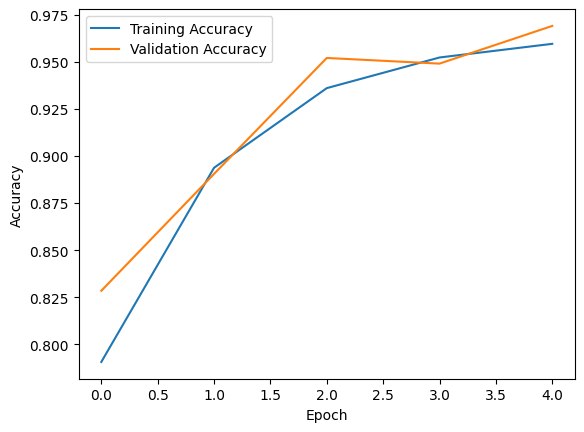

In [17]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

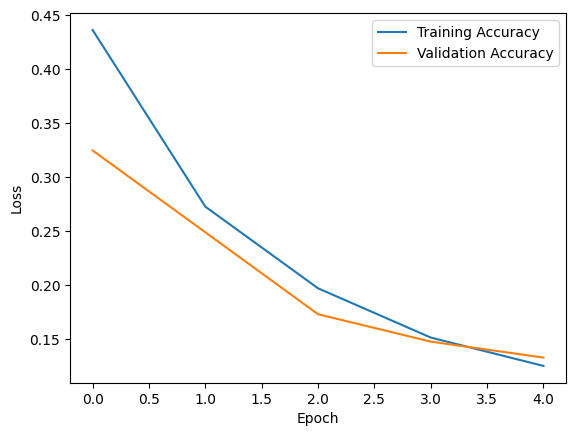

In [18]:
plt.plot(history.history['loss'], label='Training Accuracy')
plt.plot(history.history['val_loss'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Compute true labels and predictions for the training dataset without shuffle
y_train_true = np.concatenate([y for _, y in train_dataset_noshuffle.as_numpy_iterator()], axis=0)
train_predictions = model.predict(train_dataset_noshuffle)

# Split training predictions by labels
train_predictions_0 = train_predictions[y_train_true == 0]
train_predictions_1 = train_predictions[y_train_true == 1]

# Compute true labels and predictions for the validation dataset without shuffle
y_val_true = np.concatenate([y for _, y in validation_dataset.as_numpy_iterator()], axis=0)
val_predictions = model.predict(validation_dataset)

# Split validation predictions by labels
val_predictions_0 = val_predictions[y_val_true == 0]
val_predictions_1 = val_predictions[y_val_true == 1]

250/250 [==============================] - 4s 17ms/step


2024-11-16 16:11:14.101951: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2586548196081736185
2024-11-16 16:11:14.102328: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14779163920010804127
2024-11-16 16:11:14.102358: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18178211622523239523
2024-11-16 16:11:14.102396: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3070380579739779244


63/63 [==============================] - 1s 16ms/step


2024-11-16 16:11:16.288329: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2586548196081736185
2024-11-16 16:11:16.288396: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14779163920010804127
2024-11-16 16:11:16.288423: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18178211622523239523
2024-11-16 16:11:16.288461: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3070380579739779244


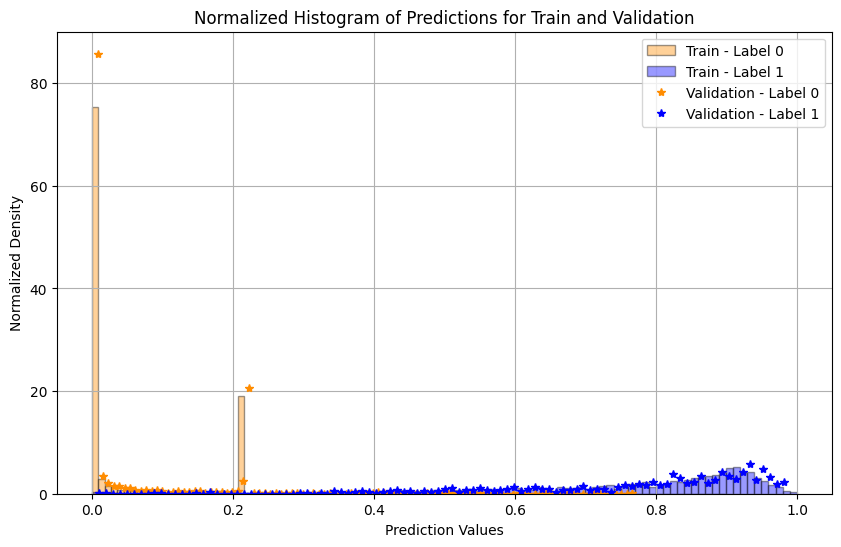

In [20]:
# Plot normalized histograms
plt.figure(figsize=(10, 6))

# Histogram for train_predictions_label_0 and train_predictions_label_1
# Normalize each histogram so that the total area equals 1
train_hist_0, bins_0, _ = plt.hist(
    train_predictions_0, bins=100, alpha=0.4, color='darkorange', 
    label='Train - Label 0', edgecolor='black', density=True
)
train_hist_1, bins_1, _ = plt.hist(
    train_predictions_1, bins=100, alpha=0.4, color='blue', 
    label='Train - Label 1', edgecolor='black', density=True
)

# Histograms for validation (without visualization)
val_hist_0, bin_val_0 = np.histogram(val_predictions_0, bins=100, density=True)
val_hist_1, bin_val_1 = np.histogram(val_predictions_1, bins=100, density=True)

# Plot validation histograms
plt.plot(bin_val_0[1:], val_hist_0, '*', color='darkorange', label='Validation - Label 0')
plt.plot(bin_val_1[1:], val_hist_1, '*', color='blue', label='Validation - Label 1')

# Add labels and legend
plt.xlabel("Prediction Values")
plt.ylabel("Normalized Density")
plt.title("Normalized Histogram of Predictions for Train and Validation")
plt.legend()
plt.grid(True)

plt.show()

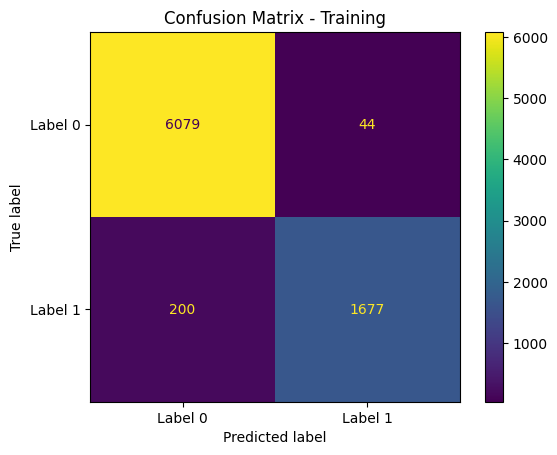

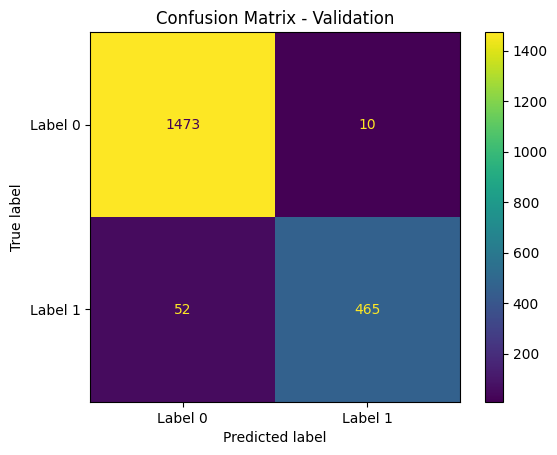

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predictions for the entire dataset
y_train_pred = (train_predictions >= 0.5).astype(int)
y_val_pred = (val_predictions >= 0.5).astype(int)

# Compute the confusion matrix for training
train_cm = confusion_matrix(y_train_true, y_train_pred)
ConfusionMatrixDisplay(train_cm, display_labels=['Label 0', 'Label 1']).plot()
plt.title('Confusion Matrix - Training')
plt.show()

# Compute the confusion matrix for validation
val_cm = confusion_matrix(y_val_true, y_val_pred)
ConfusionMatrixDisplay(val_cm, display_labels=['Label 0', 'Label 1']).plot()
plt.title('Confusion Matrix - Validation')
plt.show()

## Test only dense model

In [22]:
# Input for Dense layer
input_dE = Input(shape=(16,), name="dE_input")
x4 = Dense(4, activation="relu")(input_dE)

# Output for binary classification
output = Dense(1, activation="sigmoid", name="output")(x4)

# Define the model
model_dense = Model(inputs=[input_dE], outputs=output)

In [23]:
# Compile the model
model_dense.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", AUC()])

# Display the model summary
model_dense.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dE_input (InputLayer)       [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
 output (Dense)              (None, 1)                 5         
                                                                 
Total params: 73 (292.00 Byte)
Trainable params: 73 (292.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


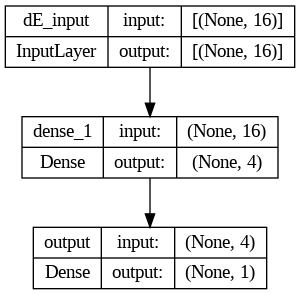

In [24]:
keras.utils.plot_model(model_dense, "dense_model.png", show_shapes=True)

In [25]:
# Train the model
history_dense = model_dense.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5
)

Epoch 1/5


/envs/cnn-k2/lib/python3.10/site-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['posdE_01xy_input', 'posdE_23x_input', 'posdE_23y_input'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


250/250 [==============================] - 6s 19ms/step - loss: 0.6060 - accuracy: 0.7736 - auc_1: 0.6279 - val_loss: 0.3391 - val_accuracy: 0.9300 - val_auc_1: 0.9598


2024-11-16 16:11:23.876877: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5267622048214968463
2024-11-16 16:11:23.877171: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 567501316788233092


Epoch 2/5
250/250 [==============================] - 5s 19ms/step - loss: 0.2674 - accuracy: 0.9442 - auc_1: 0.9727 - val_loss: 0.2405 - val_accuracy: 0.9545 - val_auc_1: 0.9740
Epoch 3/5
250/250 [==============================] - 6s 21ms/step - loss: 0.2050 - accuracy: 0.9617 - auc_1: 0.9833 - val_loss: 0.1963 - val_accuracy: 0.9610 - val_auc_1: 0.9797
Epoch 4/5
250/250 [==============================] - 6s 20ms/step - loss: 0.1668 - accuracy: 0.9664 - auc_1: 0.9878 - val_loss: 0.1596 - val_accuracy: 0.9670 - val_auc_1: 0.9879
Epoch 5/5
250/250 [==============================] - 5s 19ms/step - loss: 0.1389 - accuracy: 0.9725 - auc_1: 0.9911 - val_loss: 0.1347 - val_accuracy: 0.9700 - val_auc_1: 0.9903


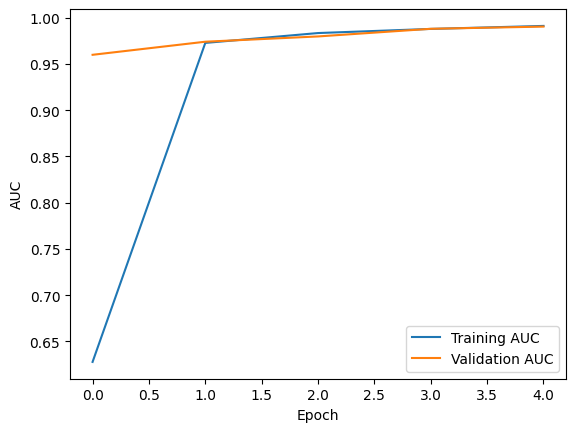

In [26]:
plt.plot(history_dense.history['auc_1'], label='Training AUC')
plt.plot(history_dense.history['val_auc_1'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

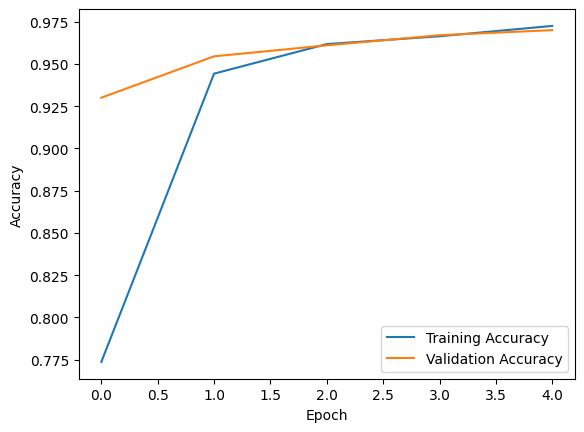

In [27]:
plt.plot(history_dense.history['accuracy'], label='Training Accuracy')
plt.plot(history_dense.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

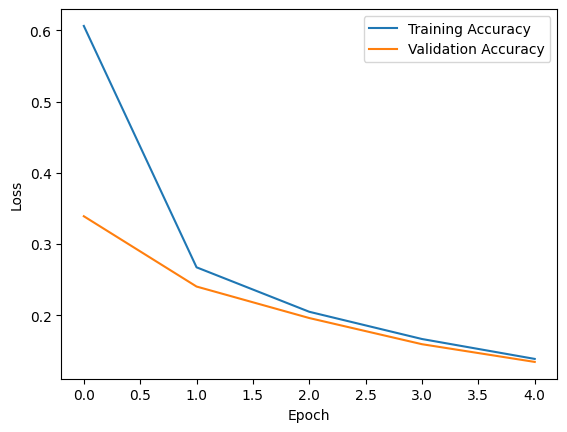

In [28]:
plt.plot(history_dense.history['loss'], label='Training Accuracy')
plt.plot(history_dense.history['val_loss'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# Calculate labels and predictions for the training dataset without shuffle
train_predictions_dense = model_dense.predict(train_dataset_noshuffle)

# Split training predictions by labels
train_predictions_0 = train_predictions_dense[y_train_true == 0]
train_predictions_1 = train_predictions_dense[y_train_true == 1]

# Calculate labels and predictions for the validation dataset without shuffle
val_predictions_dense = model_dense.predict(validation_dataset)

# Split validation predictions by labels
val_predictions_0 = val_predictions_dense[y_val_true == 0]
val_predictions_1 = val_predictions_dense[y_val_true == 1]

250/250 [==============================] - 4s 16ms/step


2024-11-16 16:11:52.925057: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5267622048214968463


63/63 [==============================] - 1s 16ms/step


2024-11-16 16:11:54.179330: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5267622048214968463


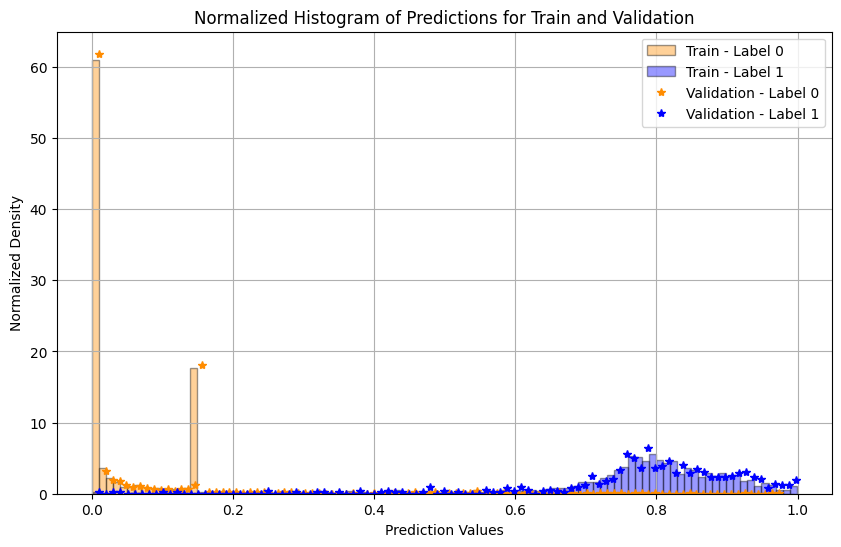

In [30]:
# Plot normalized histograms
plt.figure(figsize=(10, 6))

# Histogram for train_predictions_label_0 and train_predictions_label_1
# Normalize each histogram so that the total area equals 1
train_hist_0, bins_0, _ = plt.hist(
    train_predictions_0, bins=100, alpha=0.4, color='darkorange', 
    label='Train - Label 0', edgecolor='black', density=True
)
train_hist_1, bins_1, _ = plt.hist(
    train_predictions_1, bins=100, alpha=0.4, color='blue', 
    label='Train - Label 1', edgecolor='black', density=True
)

# Histograms for validation (without direct plotting)
val_hist_0, bin_val_0 = np.histogram(val_predictions_0, bins=100, density=True)
val_hist_1, bin_val_1 = np.histogram(val_predictions_1, bins=100, density=True)

# Plot validation histograms
plt.plot(bin_val_0[1:], val_hist_0, '*', color='darkorange', label='Validation - Label 0')
plt.plot(bin_val_1[1:], val_hist_1, '*', color='blue', label='Validation - Label 1')

# Add labels and legend
plt.xlabel("Prediction Values")
plt.ylabel("Normalized Density")
plt.title("Normalized Histogram of Predictions for Train and Validation")
plt.legend()
plt.grid(True)

plt.show()

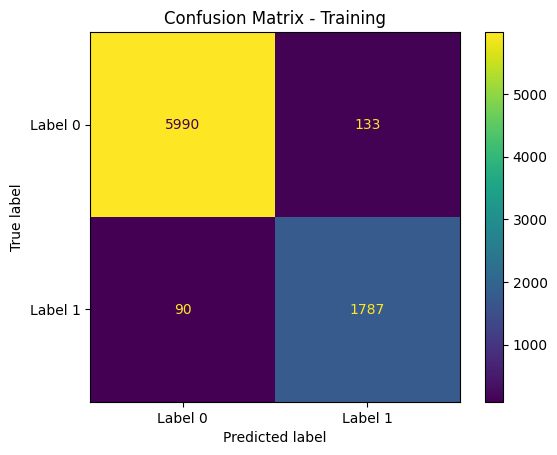

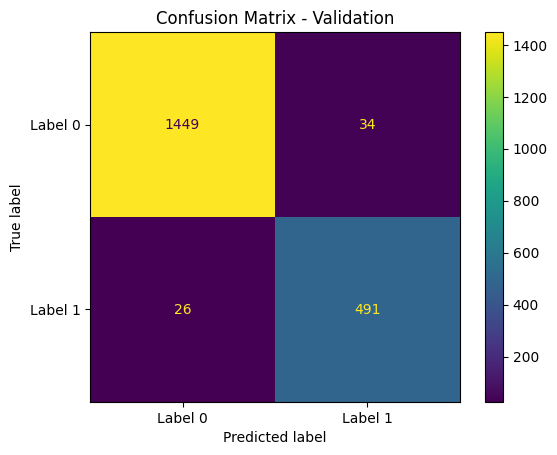

In [31]:
# Predictions for the entire dataset
y_train_pred_dense = (train_predictions_dense >= 0.5).astype(int)
y_val_pred_dense = (val_predictions_dense >= 0.5).astype(int)

# Compute the confusion matrix for training
train_cm = confusion_matrix(y_train_true, y_train_pred_dense)
ConfusionMatrixDisplay(train_cm, display_labels=['Label 0', 'Label 1']).plot()
plt.title('Confusion Matrix - Training')
plt.show()

# Compute the confusion matrix for validation
val_cm = confusion_matrix(y_val_true, y_val_pred_dense)
ConfusionMatrixDisplay(val_cm, display_labels=['Label 0', 'Label 1']).plot()
plt.title('Confusion Matrix - Validation')
plt.show()

In [32]:
# comparison of roc curves from different models
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc(X, c, model, title, fmt=''):
  fpr, tpr, thresholds = roc_curve(c, X)
  plt.plot(1.0 - fpr, tpr, fmt, label=f'{title} (AUC: {100*roc_auc_score(c,X):.1f}%)')

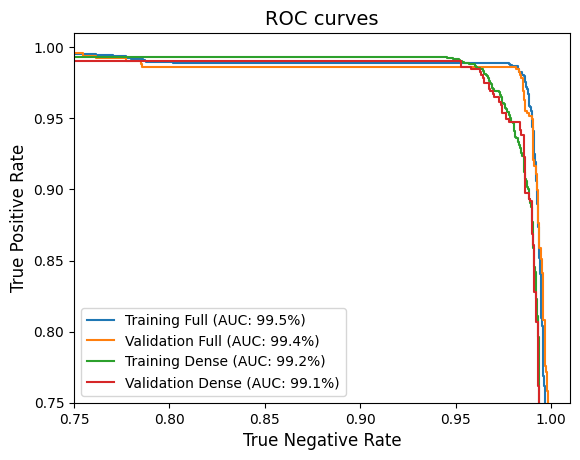

In [33]:
plt.title("ROC curves", fontsize=14)
plt.xlabel("True Negative Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)

plot_roc(train_predictions, y_train_true, model, 'Training Full')
plot_roc(val_predictions, y_val_true, model, "Validation Full")
plot_roc(train_predictions_dense, y_train_true, model_dense, 'Training Dense')
plot_roc(val_predictions_dense, y_val_true, model_dense, "Validation Dense")

plt.xlim(0.75, 1.01)
plt.ylim(0.75, 1.01)
plt.legend(loc='lower left')

plt.show()